Importing necessary libraries

In [25]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer

In [6]:
# For static images:
%matplotlib inline

# For animations, try using notebook backend (if you are using Jupyter):
%matplotlib notebook


In [7]:
pd.set_option('display.max_columns', None)

### Importing Datasets

The dataset on publications were sourced from 'Web OF Science'

In [21]:
wos = pd.read_csv('wos_published_articles.csv')
research_payments = pd.read_csv('research_payments.csv')

/var/folders/48/3359jr0n34v6fd5jftvl2dn00000gn/T/ipykernel_52044/781313620.py:2: DtypeWarning: Columns (2,5,8,9,10,11,18,19,20,26,32,33,34,35,36,77,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  research_payments = pd.read_csv('research_payments.csv')


In [22]:
# Step 1: Expanding 'Author Full Names' into separate records
authors_expanded = wos['Author Full Names'].str.split('; ').apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('Author Full Names')
wos_expanded = authors_expanded.join(wos.drop('Author Full Names', axis=1), how='left')

# Step 2: Handling NaNs with empty lists for columns to encode
columns_to_encode = ['Funding Name Preferred', 'Affiliations', 'WoS Categories', 'Research Areas']
for col in columns_to_encode:
    wos_expanded[col] = wos_expanded[col].str.split('; ').apply(lambda x: x if isinstance(x, list) else [])

# Step 3: Perform one-hot encoding while retaining all rows
mlb = MultiLabelBinarizer()

for col in columns_to_encode:
    encoded = mlb.fit_transform(wos_expanded[col])
    encoded_df = pd.DataFrame(encoded, index=wos_expanded.index, columns=[f"{col}_{c}" for c in mlb.classes_])
    wos_expanded = pd.concat([wos_expanded, encoded_df], axis=1)

# Prepare for aggregation
# Numeric columns to sum up
numeric_columns = ['Cited Reference Count', 'Times Cited, All Databases', 'Since 2013 Usage Count']
# All other specified columns, assuming the first non-null entry per author should be retained
specified_columns = ['Article Title', 'Email Addresses', 'Publisher', 'Publisher City']

aggregation_functions = {col: 'sum' for col in wos_expanded.columns if any(col.startswith(prefix) for prefix in columns_to_encode)}
aggregation_functions.update({col: 'sum' for col in numeric_columns if col in wos_expanded.columns})
aggregation_functions.update({col: lambda x: next((item for item in x if item), None) for col in specified_columns})

# Step 4: Aggregating metrics at the level of 'Author Full Names'
wos_grouped = wos_expanded.groupby('Author Full Names').agg(aggregation_functions).reset_index()

# Step 5: Removing 'Publication Year' from the final DataFrame
wos_grouped = wos_grouped.drop('Publication Year', axis=1, errors='ignore')

In [23]:
# List of columns to drop
columns_to_drop = [
    'Article Title',
    'Affiliations',
    'Funding Name Preferred_',
    'WoS Categories',
    'Research Areas',
    'Funding Name Preferred'
]

# Dropping the specified columns from wos_grouped
wos_grouped = wos_grouped.drop(columns=columns_to_drop, errors='ignore')

In [24]:
wos_grouped.head()

Author Full Names  \
0  (data truncated to fit)   
1                 Aaij, R.   
2       Aamodt, Whitley W.   
3    Aarabi, Mohammad Hadi   
4            Aarsland, Dag   

   Funding Name Preferred_'US National Institutes of Health (NIH)'(United States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA)  \
0                                                  0                                                                                                               
1                                                  0                                                                                                               
2                                                  0                                                                                                               
3                                                  0                                                                                                               
4                                                  0                                                                                                               

   Funding Name Preferred_(Icelandic Heart Association)  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Funding Name Preferred_(NEUROMETAB-CM) from Comunidad de Madrid  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   Funding Name Preferred_(PCUK)  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   

   Funding Name Preferred_(Ricerca corrente)(Ministry of Health, ItalyMinistry of Health Italy - Ricerca Corrente (MOH-RC))  \
0                                                  0                                                                          
1                                                  0                                                                          
2                                                  0                                                                          
3                                                  0                                                                          
4                                                  0                                                                          

   Funding Name Preferred_1.3.5 Research Funds in West China Hospital of Sichuan University  \
0                                                  0                                          
1                                                  0                                          
2                                                  0                                          
3                                                  0                                          
4                                                  0                                          

   Funding Name Preferred_1.3.5 project for disciplines of excellence, West China Hospital, Sichuan University  \
0                                                  0                                                             
1                                                  0                                                             
2                                                  0                                                             
3                                                  0        

The research payments data was sourced from open_payments_data

In [9]:
research_payments = research_payments[[
    'principal_investigator_1_first_name',
    'principal_investigator_1_middle_name',
    'principal_investigator_1_last_name',
    'applicable_manufacturer_or_applicable_gpo_making_payment_name',
    'total_amount_of_payment_usdollars',
    'date_of_payment'
]]
research_payments.head()

principal_investigator_1_first_name principal_investigator_1_middle_name  \
0                               KAMAL                                   R.   
1                               KAREN                                    H   
2                                LILY                                  NaN   
3                               PINAK                                   B.   
4                           SHIH-HSIN                                    E   

  principal_investigator_1_last_name  \
0                            KHABBAZ   
1                          ALBRITTON   
2                               CHAO   
3                               SHAH   
4                               YANG   

  applicable_manufacturer_or_applicable_gpo_making_payment_name  \
0                   Edwards Lifesciences Corporation              
1                                        PFIZER INC.              
2                                    Novo Nordisk AS              
3                   Edwards Lifesciences Corporation              
4                           PUMA BIOTECHNOLOGY, INC.              

   total_amount_of_payment_usdollars date_of_payment  
0                              100.0       8/22/2022  
1                              412.7       7/21/2022  
2                                5.7       1/20/2022  
3                            19150.0       7/27/2022  
4                             3904.0       9/19/2022

In [26]:
# Creating 'Name' column
research_payments['Name'] = research_payments['principal_investigator_1_first_name'] + ' ' + \
                            research_payments['principal_investigator_1_middle_name'].fillna('') + ' ' + \
                            research_payments['principal_investigator_1_last_name'].str.strip()

# Grouping by 'Name' and summing the payments
total_payments_by_name = research_payments.groupby('Name', as_index=False)['total_amount_of_payment_usdollars'].sum()

total_payments_by_name.head()

Name  total_amount_of_payment_usdollars
0    AAMIR  BADRUDDIN                            3345.00
1       AAMIR Z JAMAL                           12596.02
2   AAMR ARIF HEREKAR                          170211.00
3  AARATI VENKATA RAO                          506250.00
4       AARATI VS RAO                           31922.02

Merging the two Dataframes

In [37]:
# Save the updated dataframe to a CSV file
wos_grouped.to_csv('wos_grouped.csv', index=False)

In [30]:
result_df.shape[1]

2

In [31]:
result_df.shape[0]

50

## Plotting Network Diagram

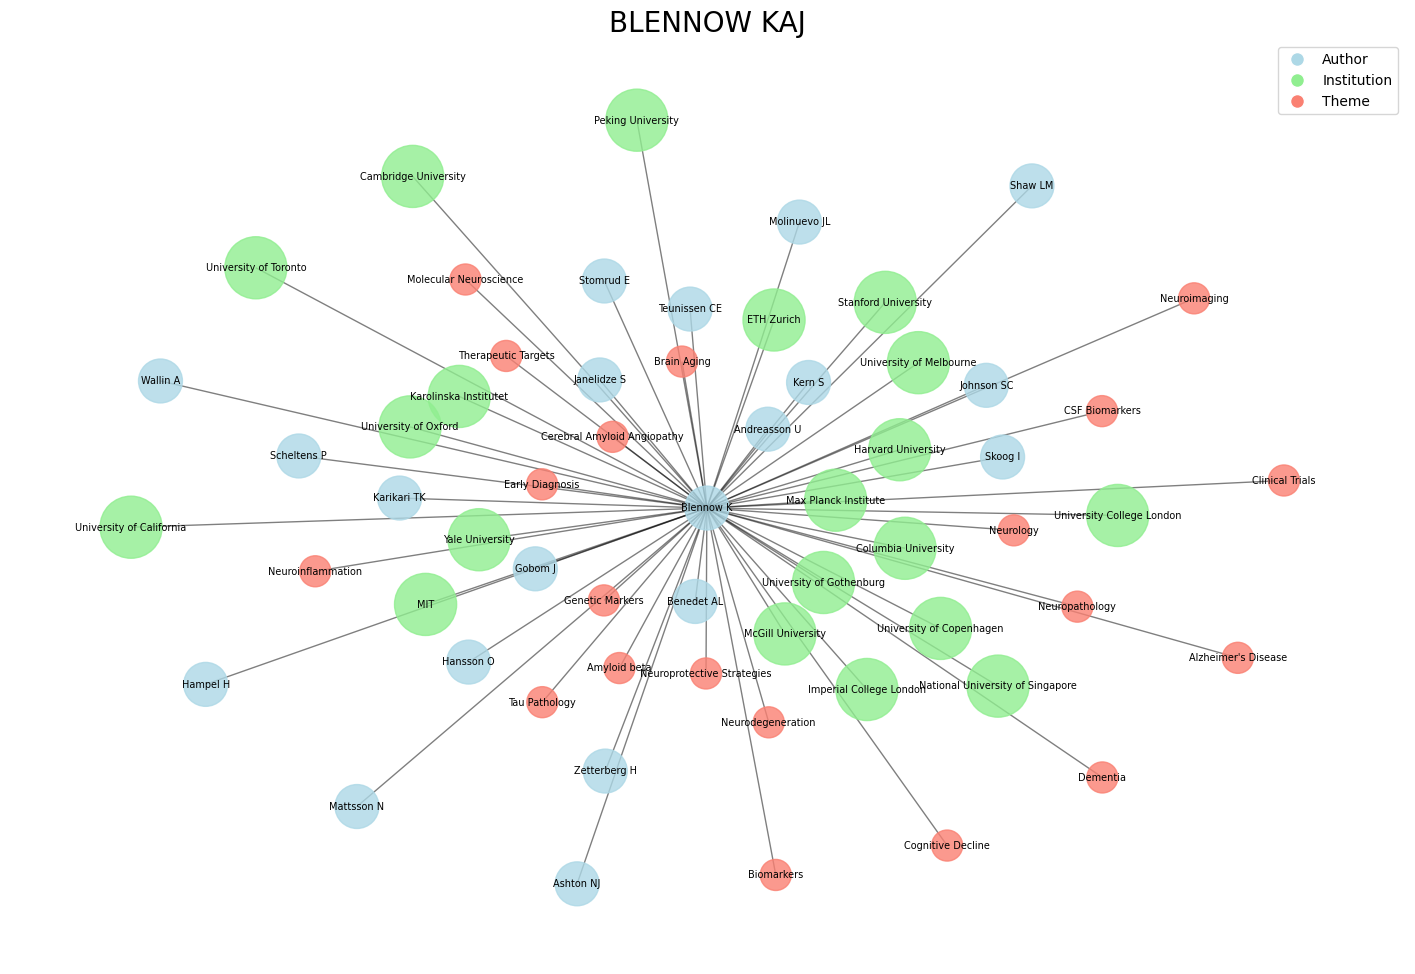

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# Initialize a new graph
G = nx.Graph()

# Define nodes for authors, institutions, and themes with sizes for demonstration
authors = ["Blennow K", "Zetterberg H", "Hansson O", "Ashton NJ", "Andreasson U",
           "Mattsson N", "Karikari TK", "Molinuevo JL", "Wallin A", "Skoog I", 
           "Hampel H", "Scheltens P", "Benedet AL", "Johnson SC", "Gobom J", 
           "Shaw LM", "Teunissen CE", "Janelidze S", "Kern S", "Stomrud E"]

institutions = ["University of Gothenburg", "Karolinska Institutet", "Harvard University", 
                "MIT", "University of California", "Stanford University", "University of Oxford", 
                "Cambridge University", "Yale University", "University of Copenhagen", 
                "Imperial College London", "University College London", "McGill University",
                "University of Melbourne", "University of Toronto", "Columbia University", 
                "Max Planck Institute", "ETH Zurich", "National University of Singapore", 
                "Peking University"]

themes = ["Alzheimer's Disease", "Neurology", "Biomarkers", "Cognitive Decline", "CSF Biomarkers",
          "Neuroimaging", "Genetic Markers", "Molecular Neuroscience", "Dementia", "Neuropathology",
          "Clinical Trials", "Neuroinflammation", "Tau Pathology", "Amyloid beta", "Neurodegeneration",
          "Brain Aging", "Cerebral Amyloid Angiopathy", "Neuroprotective Strategies", "Early Diagnosis", "Therapeutic Targets"]

# Add nodes with type and size attributes
G.add_nodes_from(authors, type='author', size=10)  # Assuming equal influence for simplicity
G.add_nodes_from(institutions, type='institution', size=20)  # Larger size for institutions
G.add_nodes_from(themes, type='theme', size=5)  # Smaller size for themes

# Randomly generate edges to simulate connections
import random
for author in authors[1:]:  # Skip Blennow himself
    G.add_edge("Blennow K", author, weight=random.randint(1, 5))
for institution in institutions:
    G.add_edge("Blennow K", institution, weight=random.randint(1, 5))
for theme in themes:
    G.add_edge("Blennow K", theme, weight=random.randint(1, 5))

# Generate positions
pos = nx.spring_layout(G, k=0.05, iterations=50)

# Drawing
plt.figure(figsize=(18, 12))

# Color coding by node type
colors = {"author": "lightblue", "institution": "lightgreen", "theme": "salmon"}
node_colors = [colors[G.nodes[node]['type']] for node in G.nodes]

# Node sizes based on type
node_sizes = [G.nodes[node]['size']*100 for node in G.nodes]  # Adjust node size based on type

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=7)

# Title and no axis for better visualization
plt.title("BLENNOW KAJ", fontsize=20)
plt.axis('off')

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Author', markersize=10, markerfacecolor='lightblue'),
                   Line2D([0], [0], marker='o', color='w', label='Institution', markersize=10, markerfacecolor='lightgreen'),
                   Line2D([0], [0], marker='o', color='w', label='Theme', markersize=10, markerfacecolor='salmon')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

<IPython.core.display.Javascript object>


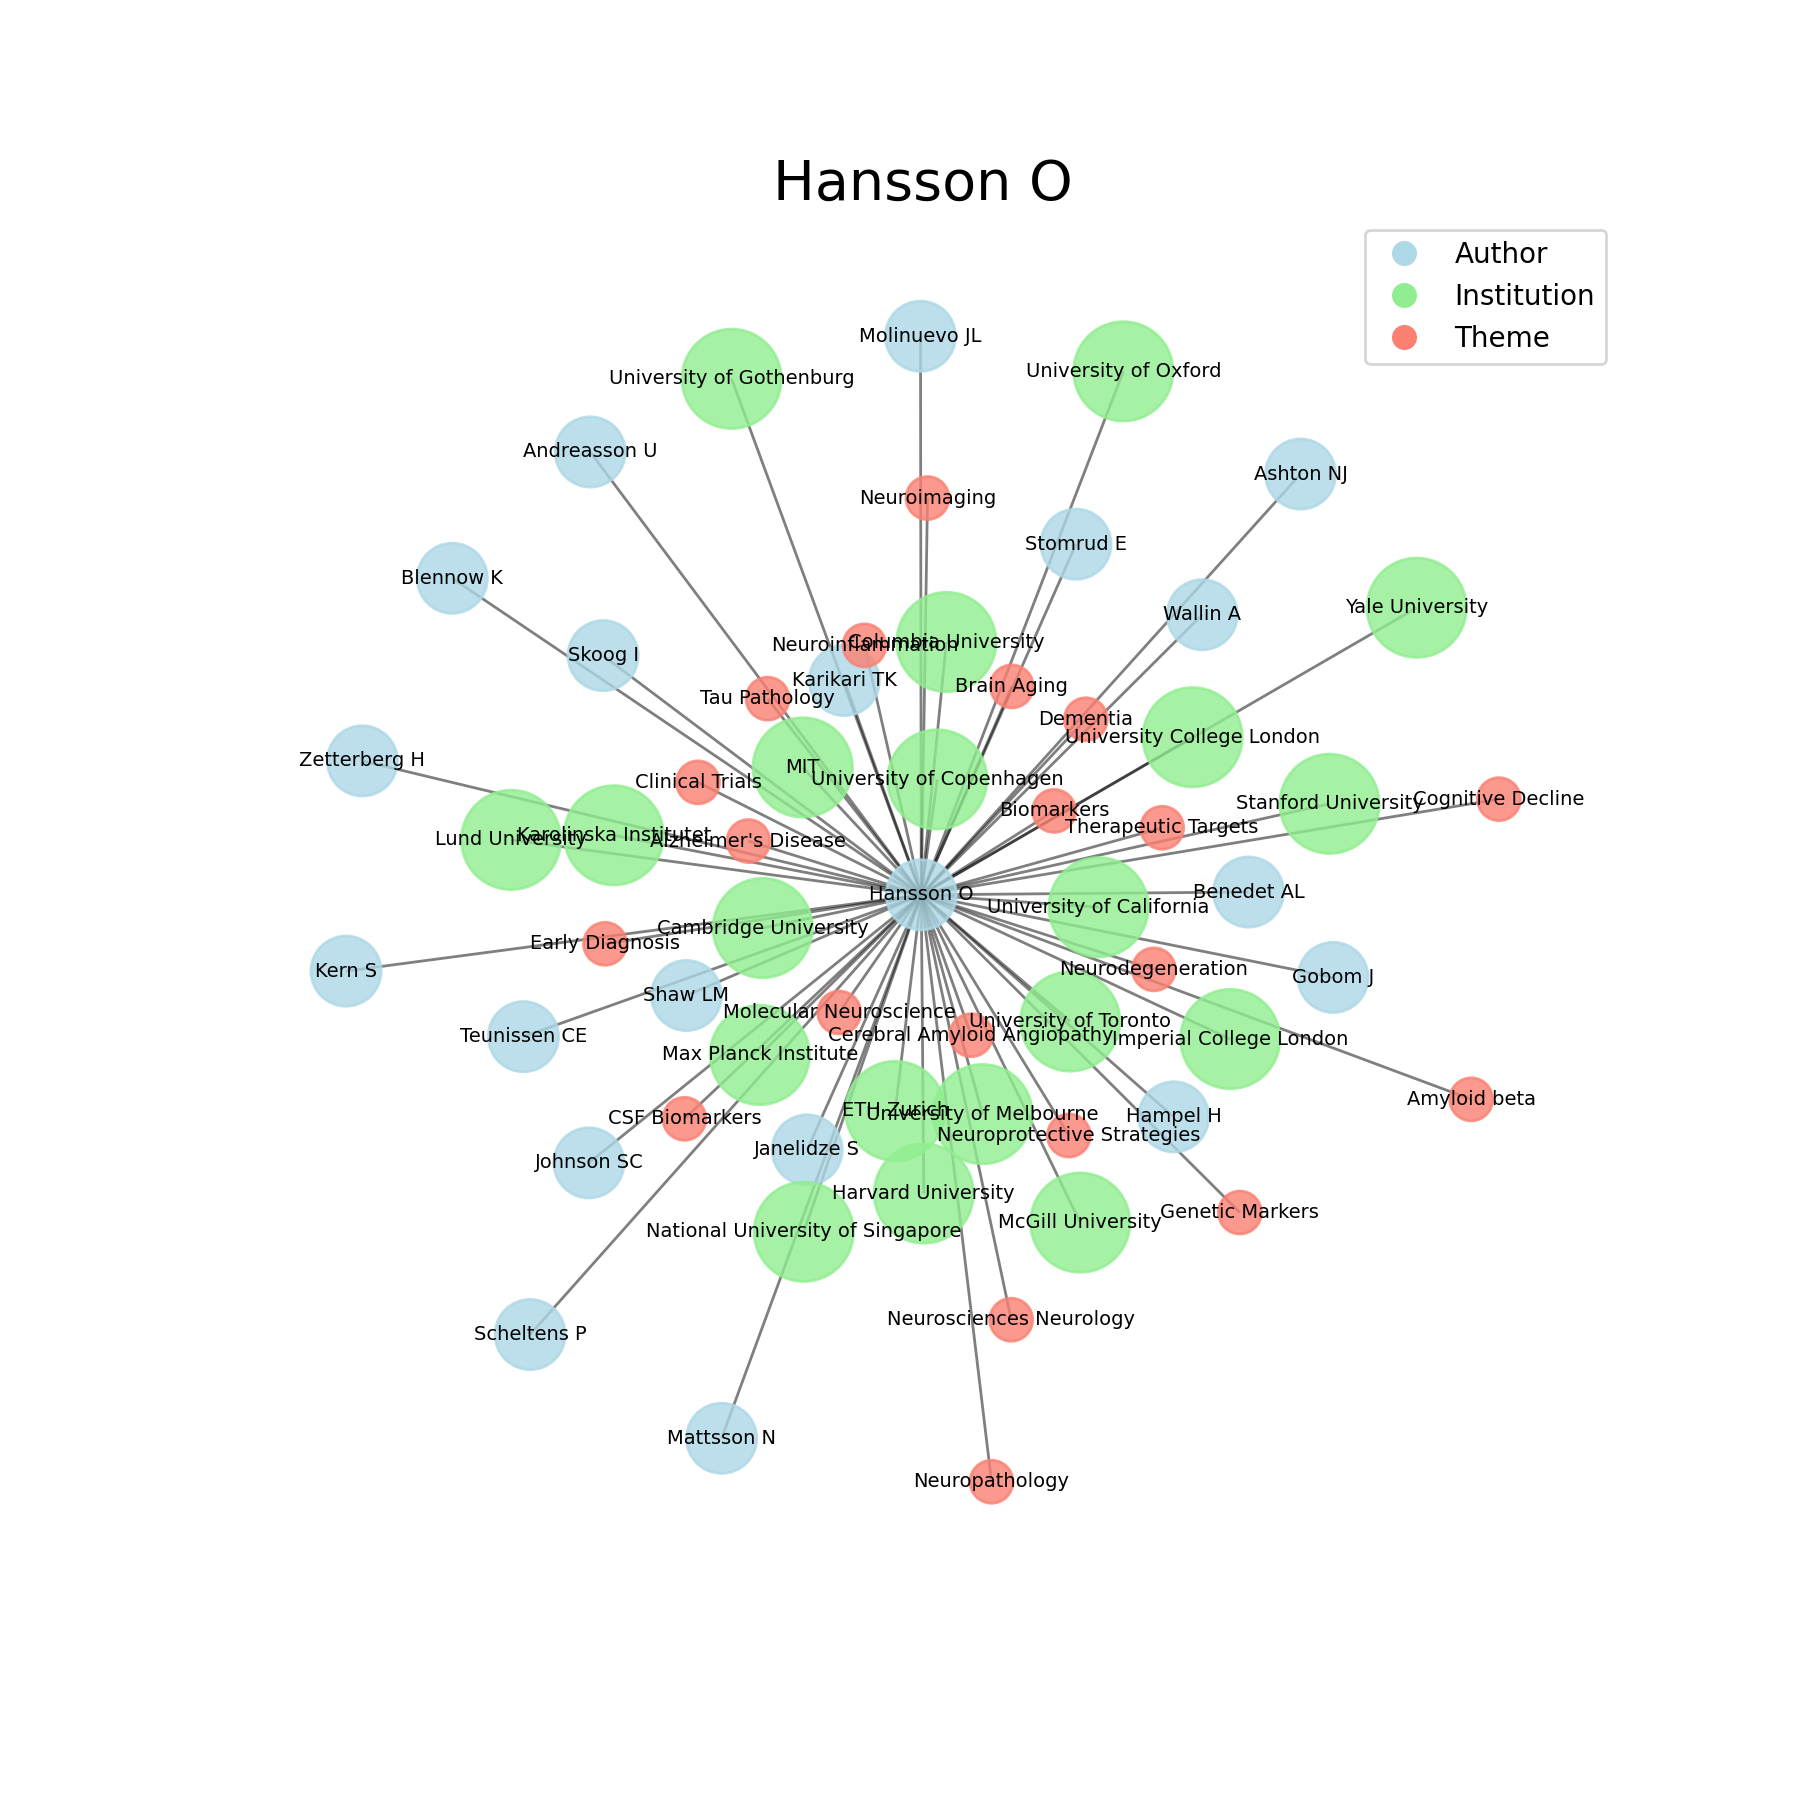

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
import random

# Initialize a new graph
G = nx.Graph()

# Define nodes for authors, institutions, and themes with sizes for demonstration
authors = ["Hansson O", "Blennow K", "Zetterberg H", "Stomrud E", "Janelidze S",
           "Ashton NJ", "Andreasson U", "Mattsson N", "Karikari TK", "Molinuevo JL", 
           "Wallin A", "Skoog I", "Hampel H", "Scheltens P", "Benedet AL", 
           "Johnson SC", "Gobom J", "Shaw LM", "Teunissen CE", "Kern S"]

institutions = ["Lund University", "University of Gothenburg", "Karolinska Institutet", 
                "Harvard University", "MIT", "University of California", "Stanford University", 
                "University of Oxford", "Cambridge University", "Yale University", 
                "University of Copenhagen", "Imperial College London", 
                "University College London", "McGill University", "University of Melbourne", 
                "University of Toronto", "Columbia University", "Max Planck Institute", 
                "ETH Zurich", "National University of Singapore"]

themes = ["Neurosciences Neurology", "Alzheimer's Disease", "Biomarkers", "Cognitive Decline", 
          "CSF Biomarkers", "Neuroimaging", "Genetic Markers", "Molecular Neuroscience", 
          "Dementia", "Neuropathology", "Clinical Trials", "Neuroinflammation", 
          "Tau Pathology", "Amyloid beta", "Neurodegeneration", "Brain Aging", 
          "Cerebral Amyloid Angiopathy", "Neuroprotective Strategies", "Early Diagnosis", 
          "Therapeutic Targets"]

# Add nodes with type and size attributes
G.add_nodes_from(authors, type='author', size=8)
G.add_nodes_from(institutions, type='institution', size=16)
G.add_nodes_from(themes, type='theme', size=3)

# Simulate connections for Hansson O
for author in authors:
    if author != "Hansson O":  # Avoid self-connection
        G.add_edge("Hansson O", author, weight=random.randint(1, 5))
for institution in institutions:
    G.add_edge("Hansson O", institution, weight=random.randint(1, 5))
for theme in themes:
    G.add_edge("Hansson O", theme, weight=random.randint(1, 5))

# Generate positions
pos = nx.spring_layout(G, k=0.05, iterations=50)

# Drawing
plt.figure(figsize=(9, 9))

# Color coding by node type
colors = {"author": "lightblue", "institution": "lightgreen", "theme": "salmon"}
node_colors = [colors[G.nodes[node]['type']] for node in G.nodes]

# Node sizes based on type
node_sizes = [G.nodes[node]['size']*80 for node in G.nodes]

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=7)

# Title and no axis for better visualization
plt.title("Hansson O", fontsize=20)
plt.axis('off')

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Author', markersize=10, markerfacecolor='lightblue'),
                   Line2D([0], [0], marker='o', color='w', label='Institution', markersize=10, markerfacecolor='lightgreen'),
                   Line2D([0], [0], marker='o', color='w', label='Theme', markersize=10, markerfacecolor='salmon')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()
